In [10]:
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, Dense, Flatten, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt

In [11]:
ata = pd.read_csv('D:\\financial_time_series\\bitcoin_price_history.csv', parse_dates=['startTime'])

data['startTime'] = pd.to_datetime(data['startTime'])
data.set_index('startTime', inplace=True)

data.sort_index(inplace=True)

def create_features(df):
    df['lag1'] = df['closePrice'].shift(1)
    df['lag2'] = df['closePrice'].shift(2)
    df['lag3'] = df['closePrice'].shift(3)
    df['rolling_mean'] = df['closePrice'].rolling(window=5).mean()
    df['rolling_std'] = df['closePrice'].rolling(window=5).std()
    df['volume_rolling_mean'] = df['volume'].rolling(window=5).mean()
    df['turnover_rolling_mean'] = df['turnover'].rolling(window=5).mean()

    df = df.dropna()

    return df

data = create_features(data)

In [12]:
X = data[['lag1', 'lag2', 'lag3', 'rolling_mean', 'rolling_std', 'volume_rolling_mean', 'turnover_rolling_mean']].values
y = data['closePrice'].values

scaler_X = MinMaxScaler()
X_scaled = scaler_X.fit_transform(X)

scaler_y = MinMaxScaler()
y_scaled = scaler_y.fit_transform(y.reshape(-1, 1))

X_scaled = X_scaled.reshape((X_scaled.shape[0], X_scaled.shape[1], 1))

X_train, X_test, y_train, y_test = train_test_split(X_scaled, y_scaled, test_size=0.2, shuffle=False)

In [13]:
model = Sequential()

model.add(Conv1D(filters=64, kernel_size=3, activation='relu', padding='causal', input_shape=(X_train.shape[1], 1)))
model.add(Dropout(0.2))

model.add(Conv1D(filters=32, kernel_size=3, activation='relu', padding='causal'))
model.add(Dropout(0.2))

model.add(Flatten())
model.add(Dense(50, activation='relu'))
model.add(Dense(1))

model.compile(optimizer=Adam(learning_rate=0.001), loss='mean_squared_error')

early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

history = model.fit(
    X_train, y_train,
    epochs=100,  # Увеличиваем количество эпох для лучшего обучения
    batch_size=32,
    validation_data=(X_test, y_test),
    callbacks=[early_stop],
    verbose=1
)

Epoch 1/100


D:\financial_time_series\.venv\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


46/46 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0465 - val_loss: 0.0032
Epoch 2/100
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0027 - val_loss: 0.0015
Epoch 3/100
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0022 - val_loss: 0.0024
Epoch 4/100
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0018 - val_loss: 0.0047
Epoch 5/100
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0017 - val_loss: 0.0023
Epoch 6/100
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0013 - val_loss: 0.0015
Epoch 7/100
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0015 - val_loss: 0.0018
Epoch 8/100
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0025 - val_loss: 0.0017
Epoch 9/100
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0016 - val_loss: 0.0022
Epoch 10/100
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0011 - val_loss: 0.0027
Epoch 11/100
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0011 - val_loss: 0.0027
Epoch 12/100
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0011 - val_lo

In [14]:
y_pred = model.predict(X_test)

y_pred_rescaled = scaler_y.inverse_transform(y_pred)
y_test_rescaled = scaler_y.inverse_transform(y_test)

12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


In [15]:
mse = mean_squared_error(y_test_rescaled, y_pred_rescaled)
print(f'Root Mean Squared Error (MSE): {mse:.4f}')

Root Mean Squared Error (MSE): 6241970.4941


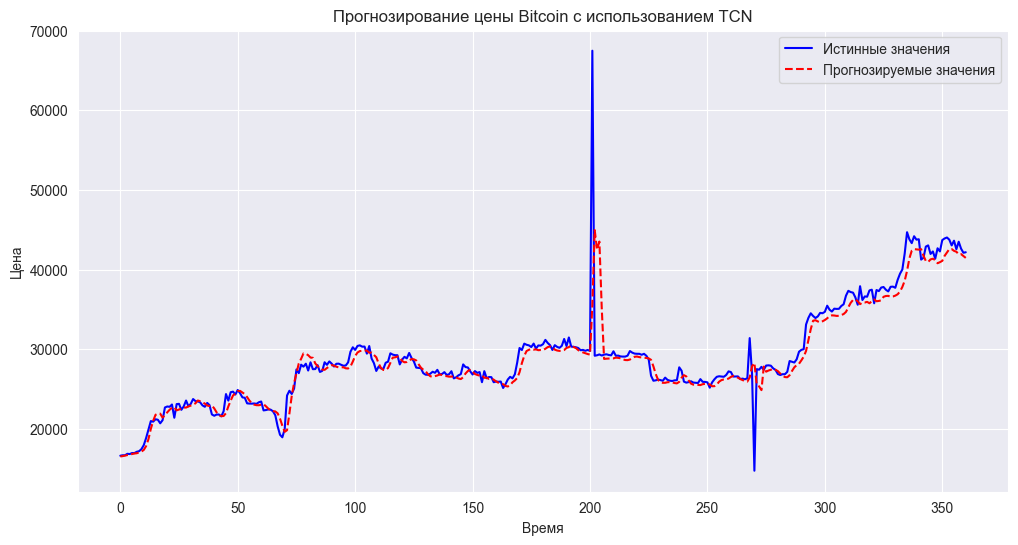

In [16]:
plt.figure(figsize=(12, 6))
plt.plot(y_test_rescaled, color='blue', label='Истинные значения')
plt.plot(y_pred_rescaled, color='red', label='Прогнозируемые значения', linestyle='--')
plt.title('Прогнозирование цены Bitcoin с использованием TCN')
plt.xlabel('Время')
plt.ylabel('Цена')
plt.legend()
plt.grid(True)
plt.show()

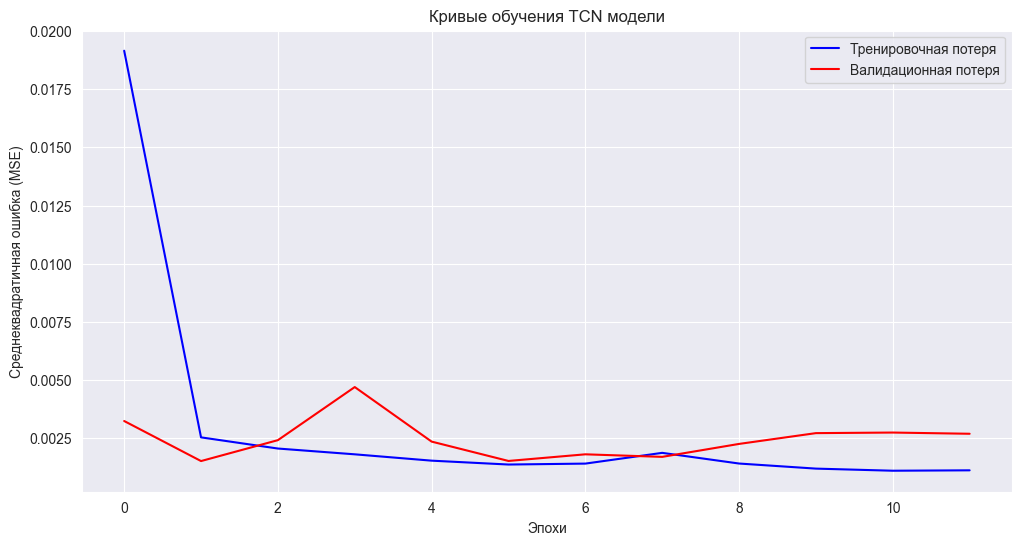

In [17]:
plt.figure(figsize=(12, 6))
plt.plot(history.history['loss'], color='blue', label='Тренировочная потеря')
plt.plot(history.history['val_loss'], color='red', label='Валидационная потеря')
plt.title('Кривые обучения TCN модели')
plt.xlabel('Эпохи')
plt.ylabel('Среднеквадратичная ошибка (MSE)')
plt.legend()
plt.grid(True)
plt.show()